# License

***

J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import pickle
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

from data_maker_and_getter import DataMakerAndGetter
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb

pd.options.display.max_columns = 999 # enable display of all columns in notebook

np.random.seed(12345)

In [2]:
%matplotlib inline

In [3]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp34em4nrj
  JVM stdout: /tmp/tmp34em4nrj/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmp34em4nrj/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,00 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,"7 days, 16 hours and 49 minutes"
H2O cluster name:,H2O_from_python_patrickh_yot18q
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#  Explore and prepare diabetes data

***

#### Import data and examine

In [4]:
# import CSV file
# set numeric categoricals to objects 

train = pd.read_csv('data/diabetes_train.csv')
train['discharge_disposition_id'] = train['discharge_disposition_id'].astype('object')
train['admission_type_id'] = train['admission_type_id'].astype('object')
train['admission_source_id'] = train['admission_source_id'].astype('object')

test = pd.read_csv('data/diabetes_test.csv')
test['discharge_disposition_id'] = test['discharge_disposition_id'].astype('object')
test['admission_type_id'] = test['admission_type_id'].astype('object')
test['admission_source_id'] = test['admission_source_id'].astype('object')

In [5]:
train.head(n=10)

,id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,?,62,0,11,0,0,0,157,288,197,7,None,None,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
8,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,Steady,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
9,42570,77586282,Caucasian,Male,[80-90),?,1,6,7,10,?,Family/GeneralPractice,55,1,31,0,0,0,428,411,427,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO


#### Examine high cardinality inputs

In [6]:
for col in train.select_dtypes(include=['object']):
    n_levels = len(train[col].unique())
    if n_levels > 20:
        print(col + ' levels: ', train[col].unique())
        print()

discharge_disposition_id levels:  [25 1 3 6 11 5 2 4 10 7 14 8 18 13 12 22 17 23 9 16 20 15 24 28 19 27]

medical_specialty levels:  ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Nephrology' 'Orthopedics-Reconstructive'
 'Surgery-Cardiovascular/Thoracic' 'Pulmonology' 'Psychiatry'
 'Emergency/Trauma' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Otolaryngology'
 'Surgery-Colon&Rectal' 'Urology' 'Psychiatry-Child/Adolescent'
 'Endocrinology' 'Neurology' 'Anesthesiology-Pediatric'
 'Pediatrics-CriticalCare' 'Radiology' 'Pediatrics-Hematology-Oncology'
 'Psychology' 'Hematology/Oncology' 'Podiatry' 'Gynecology' 'Oncology'
 'Pediatrics-Neurology' 'Surgery-Plastic' 'Surgery-Thoracic'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'Pediatrics-Pulmonology'
 'Anesthesiology' 'Ophthalmology' 'InfectiousDiseas

 '750']

diag_3 levels:  ['?' 'V27' '403' '250' 'V45' '38' '486' '197' '250.6' '427' '996' '414'
 '714' '428' '582' '250.42' '998' '250.01' '618' '250.02' '305' '496'
 '599' '424' '553' '401' '794' '511' '276' '490' '562' '482' '250.7' '518'
 '411' '784' '491' '420' '8' '730' '131' '707' '41' '493' '529' '263'
 'E888' '425' '595' '560' '711' '296' '789' 'V43' '250.4' '654' 'V70'
 '625' '681' '250.51' 'V10' '280' '440' '244' '581' '569' '272' '250.43'
 '918' '54' '250.41' '788' '196' '461' '535' '584' '891' '332' '648'
 '250.03' '780' '182' '285' '278' '997' '413' '664' '201' 'V15' '292'
 '416' '473' '564' 'E932' '357' '348' 'E878' '437' '733' '525' '250.53'
 '397' '572' '805' '453' '331' '736' '250.8' '465' '533' '787' '349' '315'
 '658' '608' '786' '284' '382' '300' 'V42' '492' '438' '571' '536' '585'
 '644' '578' '682' 'V11' 'E885' '162' '198' '303' '412' '402' '396' 'V14'
 '570' '433' 'E934' '882' '288' '458' '785' '577' '729' '836' '799' '281'
 '616' '304' '250.83' '291' '512' '660

#### Utility function for simple binning of less common categorical levels

In [7]:
def bin_less_common_levels(train, test, col_name, in_list):
    
    """Places less common categorical levels into an 'Other' bin.
    
    :param train: Training set.
    :param test: Test set.
    :param col_name: Name of column in which to create 'Other' bin.
    :param in_list: List of levels NOT to be binned.
    
    """
    
    train.loc[~train[col_name].isin(in_list), col_name] = 'Other'
    test.loc[~test[col_name].isin(in_list), col_name] = 'Other'   
                                    
    print('Train levels after binning:\n', train[col_name].value_counts())
    print()
    print('Test levels after binning:\n', test[col_name].value_counts())
    

#### Bin medical_specialty

In [8]:
in_list = list(train['discharge_disposition_id'].value_counts()[:14].index)
bin_less_common_levels(train, test, 'discharge_disposition_id', in_list)

Train levels after binning:
 1        28733
3         6599
6         5414
18        2656
11        1329
2         1116
22        1076
5          741
25         606
4          475
7          307
Other      257
14         246
13         227
23         219
Name: discharge_disposition_id, dtype: int64

Test levels after binning:
 1        9985
3        2439
6        2126
22        398
2         344
11        313
13        136
14        119
7          95
5          93
4          62
23         49
Other      47
18          8
25          7
Name: discharge_disposition_id, dtype: int64


In [9]:
in_list = list(train['medical_specialty'].value_counts()[:10].index)
bin_less_common_levels(train, test, 'medical_specialty', in_list)

Train levels after binning:
 ?                             20893
InternalMedicine               8899
Other                          5162
Family/GeneralPractice         4370
Cardiology                     3037
Emergency/Trauma               2824
Surgery-General                1649
Orthopedics-Reconstructive      898
Nephrology                      883
Orthopedics                     839
Psychiatry                      547
Name: medical_specialty, dtype: int64

Test levels after binning:
 ?                             10841
Emergency/Trauma               1735
InternalMedicine               1013
Other                           974
Cardiology                      462
Family/GeneralPractice          407
Surgery-General                 404
Orthopedics                     234
Nephrology                       64
Psychiatry                       45
Orthopedics-Reconstructive       42
Name: medical_specialty, dtype: int64


#### Bin diag_1

In [10]:
in_list = list(train['diag_1'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_1', in_list)

Train levels after binning:
 Other    25298
414       3464
428       2924
786       2071
410       1992
486       1662
427       1256
715       1103
434       1103
780        974
682        936
996        909
276        895
38         799
491        791
250.8      709
599        689
584        677
V57        651
820        590
518        508
Name: diag_1, dtype: int64

Test levels after binning:
 Other    8061
414       993
428       849
410       557
427       536
786       527
715       480
486       477
491       411
434       337
38        335
682       332
584       319
780       315
599       289
996       287
276       281
250.8     269
518       240
820       195
V57       131
Name: diag_1, dtype: int64


#### Bin diag_2

In [11]:
in_list = list(train['diag_2'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_2', in_list)

Train levels after binning:
 Other     20558
250        3425
276        3399
428        3233
427        2564
401        2094
496        1681
599        1570
403        1373
411        1358
414        1248
250.02     1060
250.01      944
707         879
780         794
285         667
682         646
518         641
425         639
491         630
424         598
Name: diag_2, dtype: int64

Test levels after binning:
 Other     8346
250        966
276        961
428        750
427        643
401        607
599        555
414        503
285        350
518        311
707        302
411        285
496        283
250.02     255
491        217
682        210
425        199
780        171
403        164
424         88
250.01      55
Name: diag_2, dtype: int64


#### Bin diag_3

In [12]:
in_list = list(train['diag_3'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_3', in_list)

Train levels after binning:
 Other     20338
250        6212
401        4473
276        2516
428        2102
427        1906
414        1701
496        1336
403        1023
272        1019
?           985
599         927
585         725
V45         686
780         662
707         640
250.02      631
285         558
250.01      541
424         522
250.6       498
Name: diag_3, dtype: int64

Test levels after binning:
 Other     7415
250       1777
401       1331
276        868
414        612
428        603
427        545
585        412
272        388
403        347
599        319
496        270
285        228
250.02     220
780        207
707        191
V45        143
250.6      124
424        101
?          100
250.01      20
Name: diag_3, dtype: int64


#### Check binning results 

In [13]:
for col in train.select_dtypes(include=['object']):
    n_levels = len(train[col].unique())
    print(col, n_levels)

race 6
gender 3
age 10
weight 9
admission_type_id 8
discharge_disposition_id 15
admission_source_id 14
payer_code 17
medical_specialty 11
diag_1 21
diag_2 21
diag_3 21
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 1
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 2
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 1
metformin-rosiglitazone 1
metformin-pioglitazone 1
change 2
diabetesMed 2
readmitted 2


#### Define target and variables to be dropped from the analysis

In [14]:
drops = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
target = 'readmitted'
encodes = list(set(train.select_dtypes(include=['object']).columns) - set(drops + [target]))

#### Dummy-encode categorical variables

In [15]:
train = pd.concat([train.drop(encodes, axis=1),
                   pd.get_dummies(train[encodes])],
                   axis = 1)

test = pd.concat([test.drop(encodes, axis=1),
                  pd.get_dummies(test[encodes])],
                   axis = 1)

#### Ensure train and test have the same input variables after encoding

In [16]:
in_train_not_test = list(set(train.columns)-set(test.columns))
train.drop(in_train_not_test, axis=1, inplace=True)

in_test_not_train = list(set(test.columns)-set(train.columns))
test.drop(in_test_not_train, axis=1, inplace=True)

In [17]:
for name in train.columns:
    
    train.rename(columns={name: name.replace('_?', '_q')}, inplace=True)
    train.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)
    
    test.rename(columns={name: name.replace('_?', '_q')}, inplace=True)
    test.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)
    

In [18]:
print('All train and test columns match:', all(train.columns == test.columns))
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

All train and test columns match: True
Train set shape: (50001, 233)
Test set shape: (16221, 233)


#### Assign modeling roles

In [19]:
# assign target and inputs for GBM
y = 'readmitted'
drops = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 
         'metformin_pioglitazone']
X = [name for name in train.columns if name not in [target] + drops + ['id', 'patient_nbr']]
print('y =', y)
print('X =', X)

y = readmitted
X = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'glipizide_metformin_No', 'weight_q', 'weight_0_25_', 'weight_100_125_', 'weight_125_150_', 'weight_150_175_', 'weight_175_200_', 'weight_25_50_', 'weight_50_75_', 'weight_75_100_', 'diag_1_250_8', 'diag_1_276', 'diag_1_38', 'diag_1_410', 'diag_1_414', 'diag_1_427', 'diag_1_428', 'diag_1_434', 'diag_1_486', 'diag_1_491', 'diag_1_518', 'diag_1_584', 'diag_1_599', 'diag_1_682', 'diag_1_715', 'diag_1_780', 'diag_1_786', 'diag_1_820', 'diag_1_996', 'diag_1_Other', 'diag_1_V57', 'acarbose_No', 'acarbose_Steady', 'metformin_Down', 'metformin_No', 'metformin_Steady', 'metformin_Up', 'diag_2_250', 'diag_2_250_01', 'diag_2_250_02', 'diag_2_276', 'diag_2_285', 'diag_2_401', 'diag_2_403', 'diag_2_411', 'diag_2_414', 'diag_2_424', 'diag_2_425', 'diag_2_427', 'diag_2_428', 'diag_2_491', 'diag_2_496', 'diag_2_518', 'diag_2

#### Ensure Pandas treats target variable and all input variables as numeric

In [20]:
train[X] = train[X].apply(pd.to_numeric, errors='coerce', axis=1)
test[X] = test[X].apply(pd.to_numeric, errors='coerce', axis=1)

In [21]:
train.loc[train[y] == 'NO', y] = '0'
train.loc[train[y] != '0', y] = '1'
train[y] = train[y].apply(pd.to_numeric)

test.loc[test[y] == 'NO', y] = '0'
test.loc[test[y] != '0', y] = '1'
test[y] = test[y].apply(pd.to_numeric)

In [22]:
train[X + [y]].head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,glipizide_metformin_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,acarbose_No,acarbose_Steady,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,troglitazone_No,glyburide_metformin_No,glyburide_metformin_Steady,tolbutamide_No,tolbutamide_Steady,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,tolazamide_No,gender_Female,gender_Male,gender_Unknown_Invalid,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,diabetesMed_No,diabetesMed_Yes,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,insulin_Down,insulin_No,insulin_Steady,insulin_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,chlorpropamide_No,chlorpropamide_Steady,miglitol_Down,miglitol_No,miglitol_Steady,change_Ch,change_No,readmitted
0,1,41,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [23]:
test[X + [y]].head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,glipizide_metformin_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,acarbose_No,acarbose_Steady,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,troglitazone_No,glyburide_metformin_No,glyburide_metformin_Steady,tolbutamide_No,tolbutamide_Steady,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,tolazamide_No,gender_Female,gender_Male,gender_Unknown_Invalid,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,diabetesMed_No,diabetesMed_Yes,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,insulin_Down,insulin_No,insulin_Steady,insulin_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,chlorpropamide_No,chlorpropamide_Steady,miglitol_Down,miglitol_No,miglitol_Steady,change_Ch,change_No,readmitted
0,1,50,6,25,0,0,0,9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

#### Calculate Pearson correlation

In [24]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(train[X + [y]].corr()[y]).iloc[:-1]

,readmitted
time_in_hospital,0.068106
num_lab_procedures,0.032412
num_procedures,-0.029204
num_medications,0.055739
number_outpatient,0.055808
number_emergency,0.121695
number_inpatient,0.268620
number_diagnoses,0.103977
glipizide_metformin_No,0.000310
weight_q,-0.022140


#### Create tuple of monotonicity constraints from Pearson correlation values

In [25]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(train[X + [y]].corr()[y].values[:-1])])
mono_constraints

(1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1

# Train XGBoost with monotonicity constraints

In [26]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

In [27]:
# ~10 mins
# looks stored model as file
# if fail, runs long process

if os.path.isfile('data/model.pkl'):
    
    model = pickle.load(open('data/model.pkl', 'rb'))
    print('Pretrained model loaded from disk.')
    print('Pretrained model best_iteration' + ': ' + model.attributes()['best_iteration'])
    print('Pretrained model best_score' + ': ' + model.attributes()['best_score'])
    
    # ensure columns in test match what XGBoost is expecting
    test = test[model.feature_names]
    dtest = xgb.DMatrix(test)
    
else:    

    # determine mean y value in training
    y_mean = train[y].mean()

    params = {
         'base_score': y_mean,
         'booster': 'gbtree',
         'colsample_bytree': 0.5,
         'eta': 0.01,
         'eval_metric': 'auc',
         'max_depth': 18,
         'nthread': 4,
         'objective': 'binary:logistic',
         'reg_alpha': 0.001,
         'reg_lambda': 0.001,
         'monotone_constraints': mono_constraints,
         'seed': 12345,
         'silent': 0,
         'subsample': 0.9}

    watchlist = [(dtrain, 'train'), (dtest, 'eval')]

    model = xgb.train(
                    params, 
                    dtrain, 
                    5000,
                    early_stopping_rounds=100,
                    evals=watchlist, 
                    verbose_eval=True)

    # parameters found by grid search: https://gist.github.com/jphall663/705595e3bc72e8fdfee8fa56220503a5
    
    pickle.dump(model, open('data/model.pkl', 'wb'))

Pretrained model loaded from disk.
Pretrained model best_iteration: 1721
Pretrained model best_score: 0.729427


#### Shapley Variable importance

In [28]:
# ~ 80 mins
# looks stored values as file
# if fail, runs long process

if os.path.isfile('data/shap_values.csv'):
    
    shap_values = np.loadtxt('data/shap_values.csv', delimiter=',')
    print('Pre-caluclated Shapley values loaded from disk.')      
          
else: 
          
    shap_values = model.predict(dtest, pred_contribs=True)
    np.savetxt('data/shap_values.csv', shap_values, delimiter=',')

Pre-caluclated Shapley values loaded from disk.


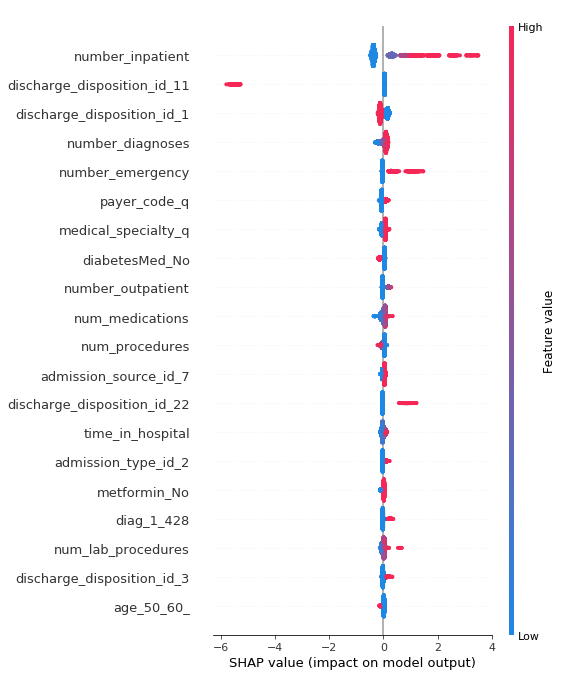

In [29]:
shap.summary_plot(shap_values[:, :-1], test[model.feature_names])

#### Function for calculating partial dependence

In [30]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [31]:
# ~ 15 mins
# looks stored values as file
# if fail, runs long process

important_vars = ['number_inpatient', 'discharge_disposition_id_11', 'discharge_disposition_id_1', 'number_diagnoses',\
                  'number_emergency']

for var in important_vars:

    fname = 'data/par_dep_' + var + '.csv'
    
    if os.path.isfile(fname):
        
        code = 'par_dep_' + var + '= pd.read_csv(fname)'
        exec(code)
        print('Partial dependence for %s loaded from disk.' % var)
    
    else: 
        
        code = 'par_dep_' + var + '= par_dep(var, test[X], model)'
        exec(code)
        code = 'par_dep_' + var + '.to_csv(fname, index=False)'
        exec(code)
        

Partial dependence for number_inpatient loaded from disk.
Partial dependence for discharge_disposition_id_11 loaded from disk.
Partial dependence for discharge_disposition_id_1 loaded from disk.
Partial dependence for number_diagnoses loaded from disk.
Partial dependence for number_emergency loaded from disk.


#### Add row ID column to test set for later joins

In [32]:
test['ID'] = np.arange(test.shape[0])

#### Bind XGBoost predictions to training data

In [33]:
xgb_preds = pd.DataFrame(model.predict(dtest))

In [34]:
test.reset_index(inplace=True)
test.drop(['index'], inplace=True, axis=1)

In [35]:
decile_frame = pd.concat([test, xgb_preds], axis=1)
decile_frame = decile_frame.rename(columns={0: 'predict'})
decile_hframe = h2o.H2OFrame(decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [36]:
decile_frame.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID,predict
0,1,50,6,25,0,0,0,9,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

#### Find percentiles of XGBoost predictions

In [37]:
ds_ = DataMakerAndGetter()
percentile_dict = ds_.get_percentile_dict('predict', 'ID', decile_hframe)

In [38]:
percentile_dict

{0: 10943,
 10: 5576,
 20: 13429,
 30: 14570,
 40: 1798,
 50: 68,
 60: 7097,
 70: 7384,
 80: 1058,
 90: 3706,
 99: 3354}

#### Calculate ICE curve values

In [39]:
for var in important_vars: 

    # retreive bins from original partial dependence calculation
    code = 'bins_%s= list(par_dep_%s["%s"])' % (var, var, var)
    exec(code)

    # for each percentile in percentile_dict
    # create a new column in the par_dep frame 
    # representing the ICE curve for that percentile
    # and the variables of interest
    for i in sorted(percentile_dict.keys()):
    
        col_name = 'Percentile_' + str(i)
    
        # ICE curves across percentiles 
        code = """par_dep_%s[col_name] = par_dep('%s', 
                                                 test[test['ID'] == int(percentile_dict[i])][model.feature_names], 
                                                 model, 
                                                 bins=bins_%s)['partial_dependence']""" % (var, var, var)
        exec(code)


#### Plot partial dependence and ICE

In [40]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


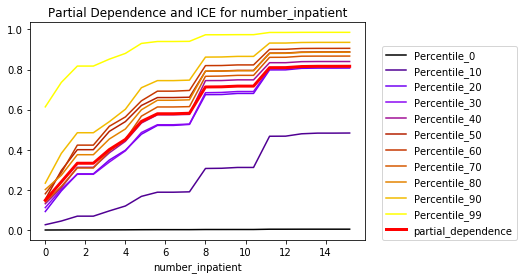

In [41]:
plot_par_dep_ICE('number_inpatient', par_dep_number_inpatient)

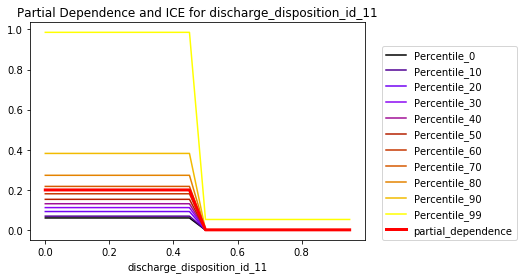

In [42]:
plot_par_dep_ICE('discharge_disposition_id_11', par_dep_discharge_disposition_id_11)

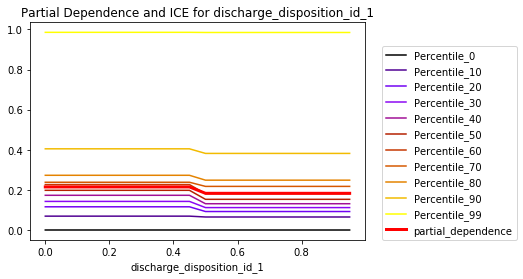

In [43]:
plot_par_dep_ICE('discharge_disposition_id_1', par_dep_discharge_disposition_id_1) # why is the bottom line flat?

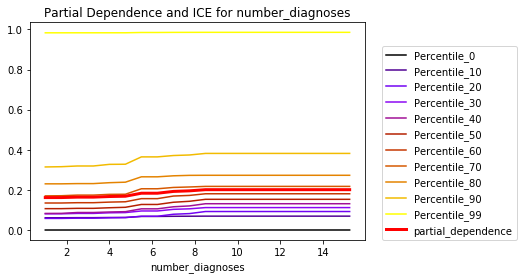

In [44]:
plot_par_dep_ICE('number_diagnoses', par_dep_number_diagnoses)

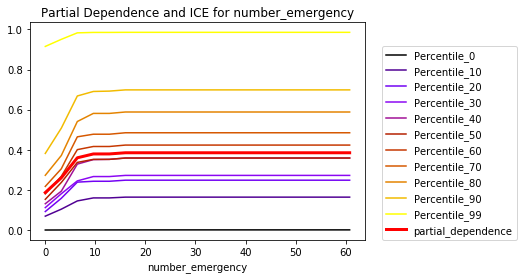

In [45]:
plot_par_dep_ICE('number_emergency', par_dep_number_emergency)

#### Train single h2o decision tree

In [46]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=4,       # shallow trees are easier to understand
                                     nfolds=3,          # check stability
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/diabetes_use_case/dt_surrogate_mojo.zip


In [47]:
surrogate.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0505445,0.0006971,0.0513149,0.0511658,0.0491530
mean_residual_deviance,0.0052504,0.0000256,0.0052780,0.0052739,0.0051993
mse,0.0052504,0.0000256,0.0052780,0.0052739,0.0051993
r2,0.7486192,0.0046901,0.7441233,0.7437376,0.7579967
residual_deviance,0.0052504,0.0000256,0.0052780,0.0052739,0.0051993
rmse,0.0724594,0.0001767,0.07265,0.0726218,0.0721064
rmsle,0.0570861,0.0002386,0.0571045,0.0574899,0.0566638


#### Create GraphViz dot file

In [48]:
# title for plot
title = 'Diabetes Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/diabetes_use_case/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Diabetes Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [49]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


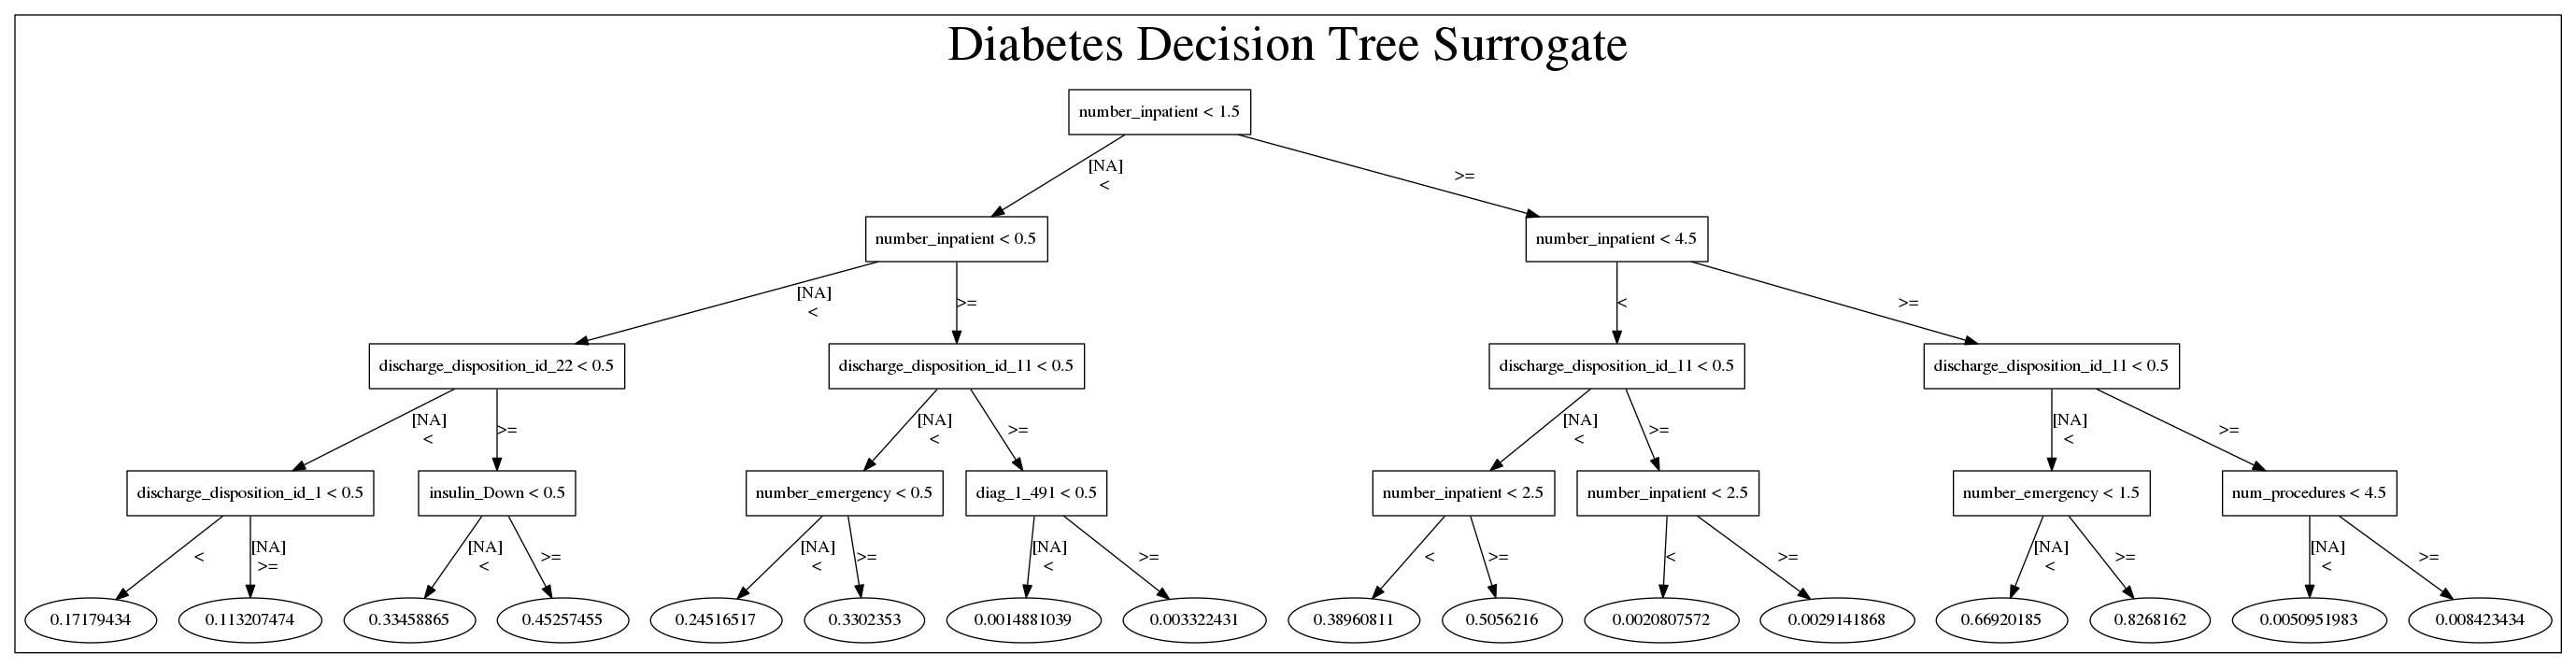

In [50]:
# display in-notebook
display(Image((png_file_name)))

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Utility function that displays the Shapley results at the choosen decile

In [51]:
def shapley(row):
    
    """ Summarize local Shapley information. 
    
    :param row: The row to explain.
    
    """
    
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(shap_values.shape[1]-1, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.iloc[-5:,:].plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [52]:
decile = 10
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                              Approximate Local Contributions
diag_2_250_01                                       -2.003291
glipizide_Down                                      -0.090288
discharge_disposition_id_4                          -0.086295
weight_50_75_                                       -0.047529
number_emergency                                    -0.038741
number_outpatient                                   -0.032679
pioglitazone_No                                     -0.029113
num_medications                                     -0.027166
diag_2_285                                          -0.027099
num_lab_procedures                                  -0.026944
diag_2_Other                                        -0.024639
admission_type_id_3                                 -0.019823
time_in_hospital                                    -0.019797
age_70_80_                                          -0.018059
weight_175_200_                                     -0.017782
diabetes

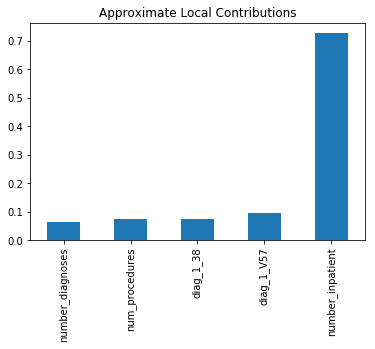

In [53]:
shapley(row)

In [54]:
row

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID,predict
5576,3,31,0,12,0,0,2,9,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

##  Median of predictions

In [55]:
decile = 50
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                              Approximate Local Contributions
number_inpatient                                    -0.395059
diag_1_V57                                          -0.130663
miglitol_Down                                       -0.108001
discharge_disposition_id_4                          -0.065117
number_emergency                                    -0.042847
time_in_hospital                                    -0.032680
number_outpatient                                   -0.030981
diag_2_285                                          -0.029631
pioglitazone_No                                     -0.023767
admission_type_id_3                                 -0.020213
acarbose_Steady                                     -0.016980
miglitol_Steady                                     -0.012212
discharge_disposition_id_18                         -0.011880
metformin_No                                        -0.010858
diabetesMed_Yes                                     -0.010858
miglitol

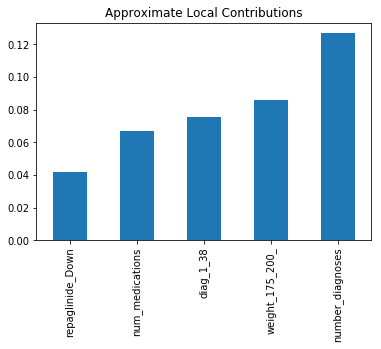

In [56]:
shapley(row)

In [57]:
row

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID,predict
68,3,60,1,19,0,0,0,9,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

##  90th decile of model predictions

In [58]:
decile = 90
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                              Approximate Local Contributions
diag_1_V57                                          -0.082025
diag_1_38                                           -0.059474
number_emergency                                    -0.040275
number_outpatient                                   -0.032355
diag_2_285                                          -0.020458
acarbose_Steady                                     -0.016557
diag_1_599                                          -0.015629
acarbose_No                                         -0.012397
weight_175_200_                                     -0.012286
metformin_No                                        -0.012285
diabetesMed_Yes                                     -0.011649
diag_1_427                                          -0.009158
diag_2_496                                          -0.009000
diag_3_424                                          -0.008501
miglitol_No                                         -0.007855
discharg

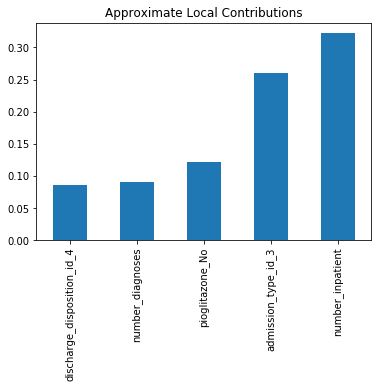

In [59]:
shapley(row) # <- model is def wrong for this person

In [60]:
row

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID,predict
3706,4,41,0,15,0,0,1,9,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0

In [61]:
h2o.cluster().shutdown()

H2O session _sid_8d24 closed.
